Baye Theorem

$$
P(\theta | D) = \frac{P(D | \theta) \cdot P(\theta)}{P(D)}
$$

In [ ]:
w1 * model1 + w2 * model2 + w3 * model3 = estimation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
np.random.seed(42) 

In [2]:
# data generator
def generate_data(prob, size=200):
    """given probability generate sample data"""
    return np.random.binomial(1, prob, size)

# generate 4 dataset
data_size = 1000
data_model1 = generate_data(1.0, data_size)  # model 1 prediction，100% label 1
data_model2 = generate_data(0.75, data_size)  # model 2 prediction，75% labei 1
data_model3 = generate_data(0.3, data_size)   # model 3 prediction，30% label 1
data_true = generate_data(0.35, data_size)     # real data，40% label 1

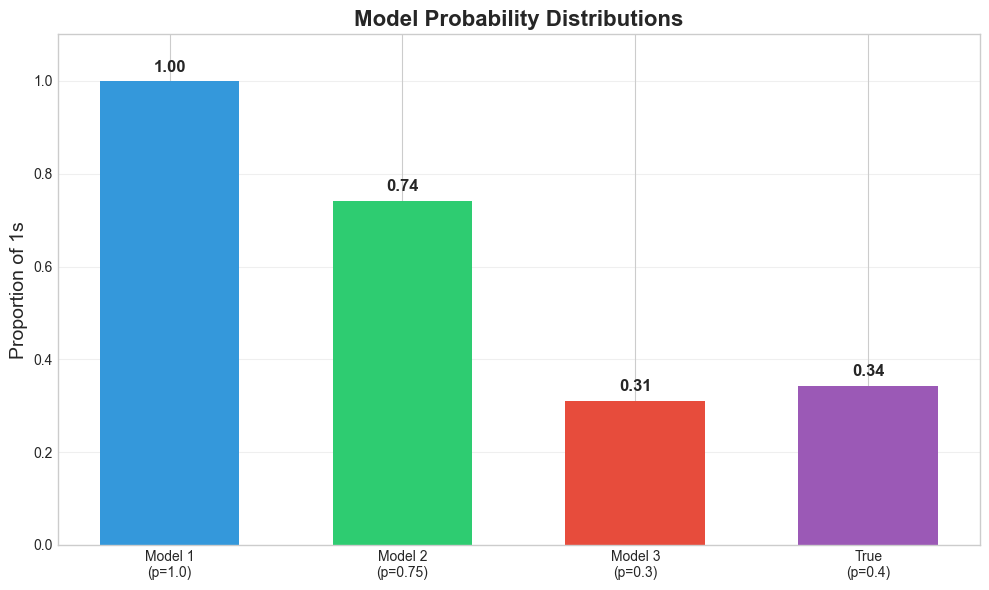

In [3]:
plt.style.use('seaborn-v0_8-whitegrid')
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']
model_colors = {'Model 1': colors[0], 'Model 2': colors[1], 'Model 3': colors[2]}

# Create a figure for model distributions
plt.figure(figsize=(10, 6))
probs = [np.mean(data_model1), np.mean(data_model2), np.mean(data_model3), np.mean(data_true)]
labels = ['Model 1\n(p=1.0)', 'Model 2\n(p=0.75)', 'Model 3\n(p=0.3)', 'True\n(p=0.4)']

bars = plt.bar(labels, probs, color=colors, width=0.6)
for bar, prob in zip(bars, probs):
    plt.text(bar.get_x() + bar.get_width()/2, prob + 0.02, f'{prob:.2f}', 
             ha='center', fontweight='bold', fontsize=12)

plt.ylim(0, 1.1)
plt.ylabel('Proportion of 1s', fontsize=14)
plt.title('Model Probability Distributions', fontsize=16, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('model_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
for i in range(len(data_true)):
    cross_entropy = -data_true[i] * np.log(data_model1[i]) - (1 - data_true[i]) * np.log(1 - data_model1[i])

In [57]:
# ------------------- Bayesian Update Functions -------------------
def compute_batch_likelihood(model_pred, true_data, batch_indices):
    """
    Compute the likelihood of observing the true data given the model prediction
    for a specific batch of data.
    
    For binary classification with Bernoulli distribution:
    P(Data|Model) = ∏ p^y_i * (1-p)^(1-y_i) where y_i is the true label
    """
    batch_pred = model_pred[batch_indices]
    batch_true = true_data[batch_indices]
    
    # To avoid numerical issues with very small probabilities, we use log-likelihood
    # log[P(Data|Model)] = ∑ [y_i*log(p) + (1-y_i)*log(1-p)]
    epsilon = 1e-15  # Small value to avoid log(0)
    
    # Clip predictions to avoid numerical issues
    batch_pred = np.clip(batch_pred, epsilon, 1 - epsilon)
    
    # Calculate log-likelihood for each sample
    log_likelihood = batch_true * np.log(batch_pred) + (1 - batch_true) * np.log(1 - batch_pred)
    
    # Sum log-likelihoods across samples
    return np.sum(log_likelihood)

def bayesian_update(priors, log_likelihoods):
    """
    Update model weights using Bayes' rule:
    P(Model|Data) ∝ P(Data|Model) * P(Model)
    
    Args:
        priors: Prior probabilities of each model
        log_likelihoods: Log-likelihoods of observing the data given each model
    
    Returns:
        Posterior probabilities (updated weights) of each model
    """
    # Convert log-likelihoods to likelihoods (exponentiate)
    # Subtract max value for numerical stability
    max_log_like = np.max(log_likelihoods)
    likelihoods = np.exp(log_likelihoods - max_log_like)
    
    # Calculate unnormalized posteriors
    unnormalized_posteriors = priors * likelihoods
    
    # Normalize to get proper probabilities
    posteriors = unnormalized_posteriors / np.sum(unnormalized_posteriors)
    
    return posteriors

def weighted_prediction(weights, model1, model2, model3):
    """Calculate weighted prediction from multiple models"""
    return weights[0] * model1 + weights[1] * model2 + weights[2] * model3

def make_decision(prob_prediction, threshold=0.5):
    """Convert probability prediction to binary decision"""
    return (prob_prediction >= threshold).astype(int)

def compute_accuracy(predictions, true_labels):
    """Compute classification accuracy"""
    return np.mean(predictions == true_labels)

Experiment Setup 

In [58]:
# Define different sets of prior weights to compare
prior_settings = {
    "Informative Prior": np.array([0.8, 0.15, 0.05]),      # Strong belief in Model 1
    "Uniform Prior": np.array([1/3, 1/3, 1/3]),          # Equal weights
    "Contradictory Prior": np.array([0.1, 0.1, 0.8])     # Strong belief in Model 3
}

# Number of batches to split the data
n_batches = 50
batch_size = data_size // n_batches

# Store results for each prior setting
all_weight_history = {}
all_accuracy_history = {}

In [59]:
for prior_name, initial_weights in prior_settings.items():
    print(f"Running experiment with {prior_name}...")
    
    # Initialize weights with the prior
    weights = initial_weights.copy()
    
    # Track weight and accuracy history
    weight_history = [weights.copy()]
    accuracy_history = []
    
    # Iterate through batches
    for batch in range(n_batches):
        # Get indices for current batch
        start_idx = batch * batch_size
        end_idx = min(start_idx + batch_size, data_size)
        batch_indices = np.arange(start_idx, end_idx)
        
        # Compute log-likelihoods for each model
        log_like1 = compute_batch_likelihood(data_model1, data_true, batch_indices)
        log_like2 = compute_batch_likelihood(data_model2, data_true, batch_indices)
        log_like3 = compute_batch_likelihood(data_model3, data_true, batch_indices)
        log_likelihoods = np.array([log_like1, log_like2, log_like3])
        
        # Update weights using Bayesian update
        weights = bayesian_update(weights, log_likelihoods)
        weight_history.append(weights.copy())
        
        # Make predictions using current weights
        current_pred = weighted_prediction(weights, data_model1, data_model2, data_model3)
        current_decision = make_decision(current_pred)
        
        # Compute accuracy on the current batch
        current_accuracy = compute_accuracy(current_decision[batch_indices], data_true[batch_indices])
        accuracy_history.append(current_accuracy)
    
    # Convert to numpy arrays
    weight_history = np.array(weight_history)
    accuracy_history = np.array(accuracy_history)
    
    # Store results
    all_weight_history[prior_name] = weight_history
    all_accuracy_history[prior_name] = accuracy_history
    
    print(f"  Initial weights: {initial_weights}")
    print(f"  Final weights: {weights}")
    print(f"  Final accuracy: {accuracy_history[-1]:.4f}")
    print()

Running experiment with Informative Prior...
  Initial weights: [0.8  0.15 0.05]
  Final weights: [0. 0. 1.]
  Final accuracy: 0.5500

Running experiment with Uniform Prior...
  Initial weights: [0.33333333 0.33333333 0.33333333]
  Final weights: [0. 0. 1.]
  Final accuracy: 0.5500

Running experiment with Contradictory Prior...
  Initial weights: [0.1 0.1 0.8]
  Final weights: [0. 0. 1.]
  Final accuracy: 0.5500



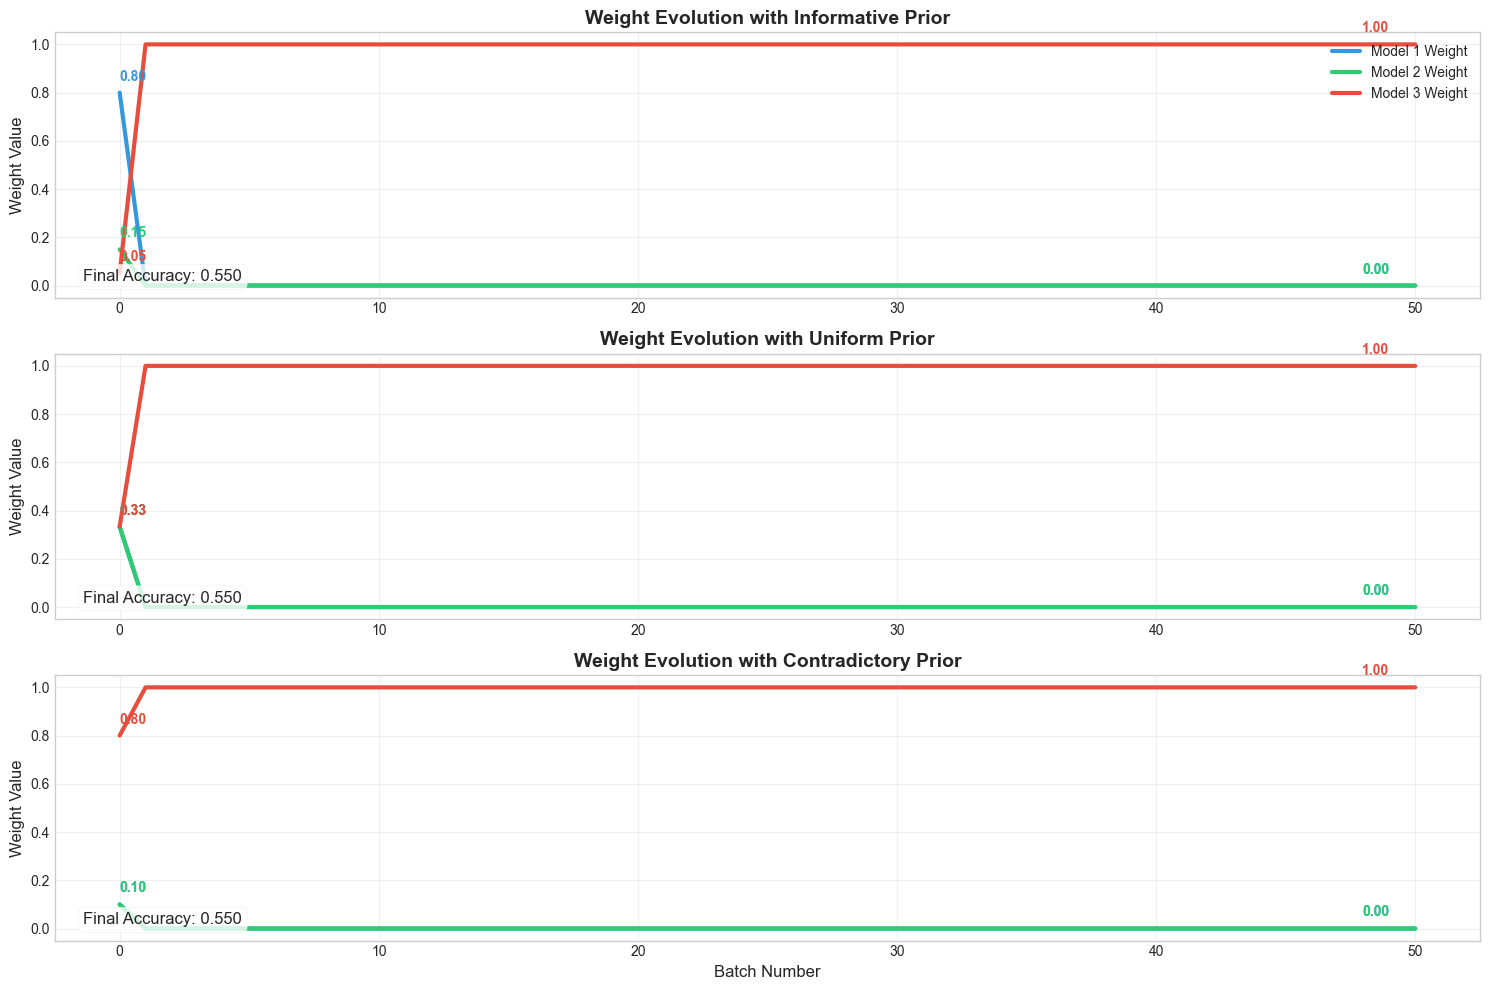

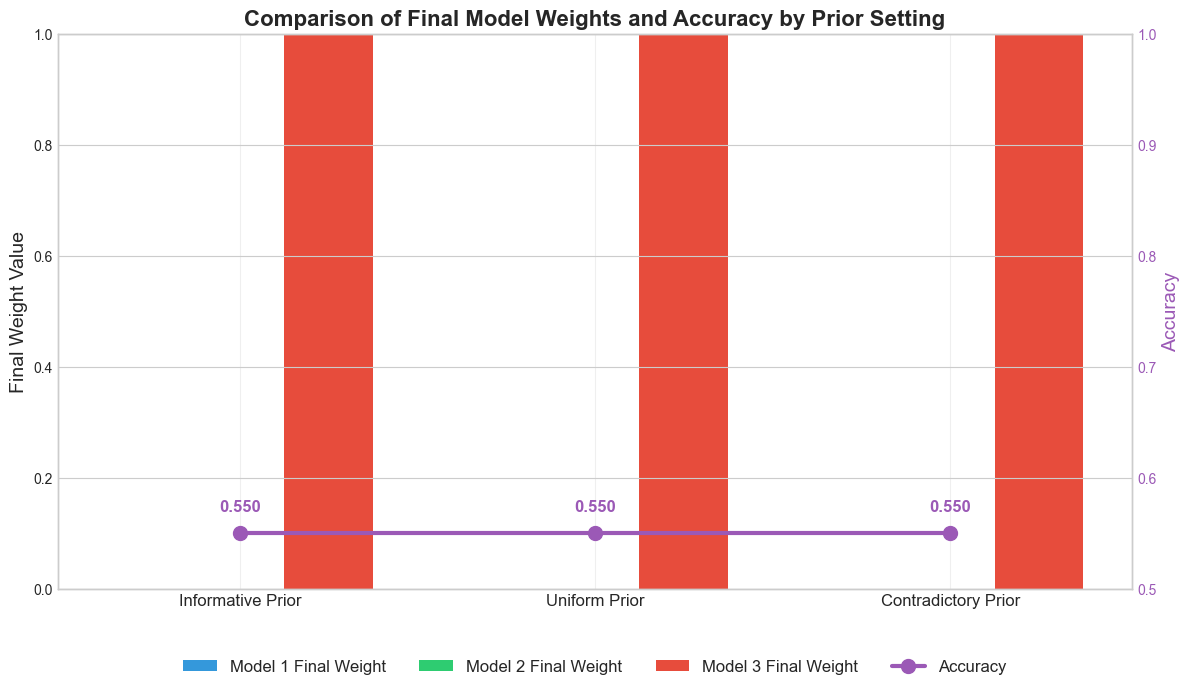


Final Comparison of All Prior Settings:
--------------------------------------------------------------------------------
Prior Setting        |  Model 1 Weight |  Model 2 Weight |  Model 3 Weight |   Accuracy
--------------------------------------------------------------------------------
Informative Prior    |          0.0000 |          0.0000 |          1.0000 |     0.5500
Uniform Prior        |          0.0000 |          0.0000 |          1.0000 |     0.5500
Contradictory Prior  |          0.0000 |          0.0000 |          1.0000 |     0.5500


In [60]:

# Create a figure for weight evolution
plt.figure(figsize=(15, 10))
prior_names = list(prior_settings.keys())

for i, prior_name in enumerate(prior_names):
    plt.subplot(len(prior_names), 1, i+1)
    weight_history = all_weight_history[prior_name]
    
    for j, model_name in enumerate(['Model 1', 'Model 2', 'Model 3']):
        plt.plot(weight_history[:, j], color=model_colors[model_name], linewidth=3, 
                 label=f'{model_name} Weight')
        
        # Annotate only the initial and final weights with text (no arrows)
        plt.text(0, weight_history[0, j] + 0.05, f'{weight_history[0, j]:.2f}', 
                 color=model_colors[model_name], fontweight='bold', ha='left')
        plt.text(len(weight_history)-2, weight_history[-1, j] + 0.05, f'{weight_history[-1, j]:.2f}', 
                 color=model_colors[model_name], fontweight='bold', ha='right')
    
    plt.title(f'Weight Evolution with {prior_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Batch Number' if i == len(prior_names)-1 else '')
    plt.ylabel('Weight Value', fontsize=12)
    plt.ylim(-0.05, 1.05)
    plt.grid(alpha=0.3)
    
    # Only include legend in the first subplot to avoid repetition
    if i == 0:
        plt.legend(loc='upper right')
    
    # Add a text box with accuracy information
    acc_history = all_accuracy_history[prior_name]
    textstr = f'Final Accuracy: {acc_history[-1]:.3f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    plt.text(0.02, 0.05, textstr, transform=plt.gca().transAxes, fontsize=12,
            verticalalignment='bottom', bbox=props)

plt.tight_layout()
plt.savefig('weight_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a summary comparison figure
plt.figure(figsize=(12, 7))

# Prepare data for comparison
final_accuracies = [all_accuracy_history[name][-1] for name in prior_names]
final_model_weights = [[all_weight_history[name][-1, j] for j in range(3)] for name in prior_names]

# Use a grouped bar chart with a more intuitive layout
width = 0.25
x = np.arange(len(prior_names))

# Create bars for each model
for j, model_name in enumerate(['Model 1', 'Model 2', 'Model 3']):
    model_final_weights = [weights[j] for weights in final_model_weights]
    plt.bar(x + (j-1)*width, model_final_weights, width, color=model_colors[model_name], 
           label=f'{model_name} Final Weight')

# Add accuracy as a separate line with right y-axis
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(x, final_accuracies, 'o-', color=colors[3], linewidth=3, markersize=10, label='Accuracy')
ax2.set_ylim(0.5, 1.0)
ax2.set_ylabel('Accuracy', color=colors[3], fontsize=14)
ax2.tick_params(axis='y', labelcolor=colors[3])

# Add accuracy values above points
for i, acc in enumerate(final_accuracies):
    ax2.text(i, acc + 0.02, f'{acc:.3f}', color=colors[3], 
             ha='center', fontweight='bold', fontsize=12)

# Finalize the plot
ax1.set_xticks(x)
ax1.set_xticklabels(prior_names, fontsize=12)
ax1.set_ylabel('Final Weight Value', fontsize=14)
ax1.set_ylim(0, 1.0)
ax1.grid(True, alpha=0.3)
ax1.set_title('Comparison of Final Model Weights and Accuracy by Prior Setting', 
             fontsize=16, fontweight='bold')

# Create a combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', 
          bbox_to_anchor=(0.5, -0.1), ncol=4, fontsize=12)

plt.tight_layout()
plt.savefig('final_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print final comparison table
print("\nFinal Comparison of All Prior Settings:")
print("-" * 80)
print(f"{'Prior Setting':<20} | {'Model 1 Weight':>15} | {'Model 2 Weight':>15} | {'Model 3 Weight':>15} | {'Accuracy':>10}")
print("-" * 80)

for prior_name in prior_names:
    final_weights = all_weight_history[prior_name][-1]
    final_acc = all_accuracy_history[prior_name][-1]
    print(f"{prior_name:<20} | {final_weights[0]:>15.4f} | {final_weights[1]:>15.4f} | {final_weights[2]:>15.4f} | {final_acc:>10.4f}")